<a href="https://colab.research.google.com/github/Fatmanurkntr/yapayZekaProjeleri/blob/main/NutriScan_Projesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

!unzip -q "/content/drive/MyDrive/YapayZekaVeriSetleri/archive.zip"

print("Yeni veri seti başarıyla açıldı!")

Yeni veri seti başarıyla açıldı!


In [7]:
# --- Veri İşleme ve Analiz Kütüphaneleri ---
import numpy as np  # Sayısal işlemler, matris ve dizi (array) operasyonları için temel kütüphane
import pandas as pd # Veriyi tablo formatında (DataFrame) işlemek, analiz etmek ve düzenlemek için
import os           # İşletim sistemiyle iletişim kurmak (dosya yolları, klasör listeleme gibi) için

# --- Görselleştirme Kütüphaneleri ---
import matplotlib.pyplot as plt # Temel grafikler (çizgi, bar, histogram vb.) çizmek için
import seaborn as sns           # Matplotlib tabanlı, daha estetik ve istatistiksel grafikler için
import plotly.express as px     # İnteraktif (fare ile üzerine gelince bilgi veren) ve modern grafikler için

# --- Görüntü İşleme ve Yapay Zeka Kütüphaneleri ---
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory # Resim dosyalarını diskten okuyup model için hazırlamak
from tensorflow.keras.models import Sequential # Model katmanlarını sırayla eklemek için
from tensorflow.keras import layers           # Modelde kullanacağımız katman türleri (Conv2D, MaxPooling vb.)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Eğitim sürecini optimize etmek için

# Grafiklerin not defterinde daha temiz görünmesi için bir stil ayarı
sns.set_style('whitegrid')

print("Tüm kütüphaneler başarıyla yüklendi ve kullanıma hazır!")

Tüm kütüphaneler başarıyla yüklendi ve kullanıma hazır!


In [8]:
# --- Veri Yollarını Tanımlama ---
# Eğitim, test ve doğrulama verilerinin bulunduğu klasör yollarını değişkenlere atıyoruz.
train_dir = 'train'
test_dir = 'test'
validation_dir = 'validation'

# --- İlk Kontrol: Klasörler Mevcut mu? ---
# os.path.exists() fonksiyonu ile bu yolların var olup olmadığını kontrol ediyoruz.
if os.path.exists(train_dir) and os.path.exists(test_dir) and os.path.exists(validation_dir):
    print("Eğitim (train), Test ve Doğrulama (validation) klasörleri başarıyla bulundu.")

    # Her bir klasördeki sınıf (meyve/sebze) sayısını bulalım.
    num_train_classes = len(os.listdir(train_dir))
    num_test_classes = len(os.listdir(test_dir))
    num_validation_classes = len(os.listdir(validation_dir))

    print(f"Eğitim setinde {num_train_classes} adet sınıf var.")
    print(f"Test setinde {num_test_classes} adet sınıf var.")
    print(f"Doğrulama setinde {num_validation_classes} adet sınıf var.")
else:
    print("HATA: Gerekli klasörlerden biri veya birkaçı bulunamadı! 'unzip' komutunu kontrol edin.")

Eğitim (train), Test ve Doğrulama (validation) klasörleri başarıyla bulundu.
Eğitim setinde 36 adet sınıf var.
Test setinde 36 adet sınıf var.
Doğrulama setinde 36 adet sınıf var.


In [9]:
# --- Sınıf ve Resim Sayılarını Hesaplama Fonksiyonu ---
# Tekrar tekrar aynı kodu yazmamak için, bir klasördeki sınıf ve resim sayılarını
# hesaplayan bir fonksiyon yazalım. Bu, temiz kodlama pratiğidir.

def analyze_directory(directory_path):
    """
    Belirtilen bir klasör yolundaki sınıf ve toplam resim sayısını analiz eder.
    Ayrıca her sınıftaki resim sayılarını bir liste olarak döndürür.
    """
    class_names = os.listdir(directory_path)
    num_classes = len(class_names)
    total_images = 0
    image_counts_per_class = []

    for class_name in class_names:
        class_dir = os.path.join(directory_path, class_name)
        num_images = len(os.listdir(class_dir))
        total_images += num_images
        image_counts_per_class.append(num_images)

    return num_classes, total_images, image_counts_per_class

# --- Her Bir Veri Seti Parçası İçin Analiz ---

# Eğitim seti analizi
train_num_classes, train_total_images, train_image_counts = analyze_directory(train_dir)
# Test seti analizi
test_num_classes, test_total_images, test_image_counts = analyze_directory(test_dir)
# Doğrulama seti analizi
val_num_classes, val_total_images, val_image_counts = analyze_directory(validation_dir)


# --- Sonuçları Anlaşılır Bir Şekilde Ekrana Yazdırma ---

print("--- Veri Seti Genel Bakış ---")
print(f"Eğitim Seti     : {train_total_images:7d} resim, {train_num_classes} sınıfta.")
print(f"Test Seti         : {test_total_images:7d} resim, {test_num_classes} sınıfta.")
print(f"Doğrulama Seti  : {val_total_images:7d} resim, {val_num_classes} sınıfta.")
print("---------------------------------")

# Toplam veriyi hesaplayalım
total_images_in_dataset = train_total_images + test_total_images + val_total_images
print(f"Toplam Veri Seti  : {total_images_in_dataset} resim.\n")


# --- DataFrame ile Daha Detaylı İnceleme ---
# Eğitim setindeki sınıf dağılımını bir DataFrame'e dönüştürelim
df_train = pd.DataFrame({
    'Sınıf': sorted(os.listdir(train_dir)), # Sınıfları alfabetik sırala
    'Eğitimdeki Resim Sayısı': sorted(train_image_counts)
})

print("Eğitim Seti Sınıf Dağılımı Özeti:")
# .describe() fonksiyonu, sayısal bir sütunun istatistiksel özetini verir (ortalama, min, max vb.)
print(df_train['Eğitimdeki Resim Sayısı'].describe())

--- Veri Seti Genel Bakış ---
Eğitim Seti     :    3115 resim, 36 sınıfta.
Test Seti         :     359 resim, 36 sınıfta.
Doğrulama Seti  :     351 resim, 36 sınıfta.
---------------------------------
Toplam Veri Seti  : 3825 resim.

Eğitim Seti Sınıf Dağılımı Özeti:
count     36.000000
mean      86.527778
std        9.207097
min       68.000000
25%       81.750000
50%       88.000000
75%       92.500000
max      100.000000
Name: Eğitimdeki Resim Sayısı, dtype: float64


In [10]:
# --- 1. GRAFİK: Veri Seti Parçalarının Karşılaştırılması (Pie Chart) ---

# Grafik için veri hazırlayalım
pie_data = {
    'Veri Seti Türü': ['Eğitim', 'Test', 'Doğrulama'],
    'Toplam Resim': [train_total_images, test_total_images, val_total_images]
}
df_pie = pd.DataFrame(pie_data)

# İnteraktif bir pasta grafiği (pie chart) çizelim
fig_pie = px.pie(
    df_pie,
    names='Veri Seti Türü',
    values='Toplam Resim',
    title='Veri Setinin Eğitim, Test ve Doğrulama Olarak Dağılımı',
    hole=0.3 # Ortasını delerek daha modern bir 'donut' grafiği yapalım
)
fig_pie.update_traces(textposition='inside', textinfo='percent+label')
fig_pie.show()


# --- 2. GRAFİK: Eğitim Setindeki Sınıf Dağılımı (Bar Chart) ---

# Bir önceki adımdaki DataFrame'i resim sayısına göre sıralayalım
df_train_sorted = df_train.sort_values(by='Eğitimdeki Resim Sayısı', ascending=False)

# İnteraktif bir bar grafiği çizelim
fig_bar = px.bar(
    data_frame=df_train_sorted,
    x='Sınıf',
    y='Eğitimdeki Resim Sayısı',
    color='Eğitimdeki Resim Sayısı', # Barların rengi sayıya göre değişsin
    title='Eğitim Setindeki Her Sınıf İçin Resim Sayısı Dağılımı'
)
fig_bar.update_layout(
    xaxis_title="Meyve ve Sebze Sınıfları",
    yaxis_title="Toplam Resim Sayısı"
)
fig_bar.show()

Her sınıftan rastgele bir örnek görsel yükleniyor...


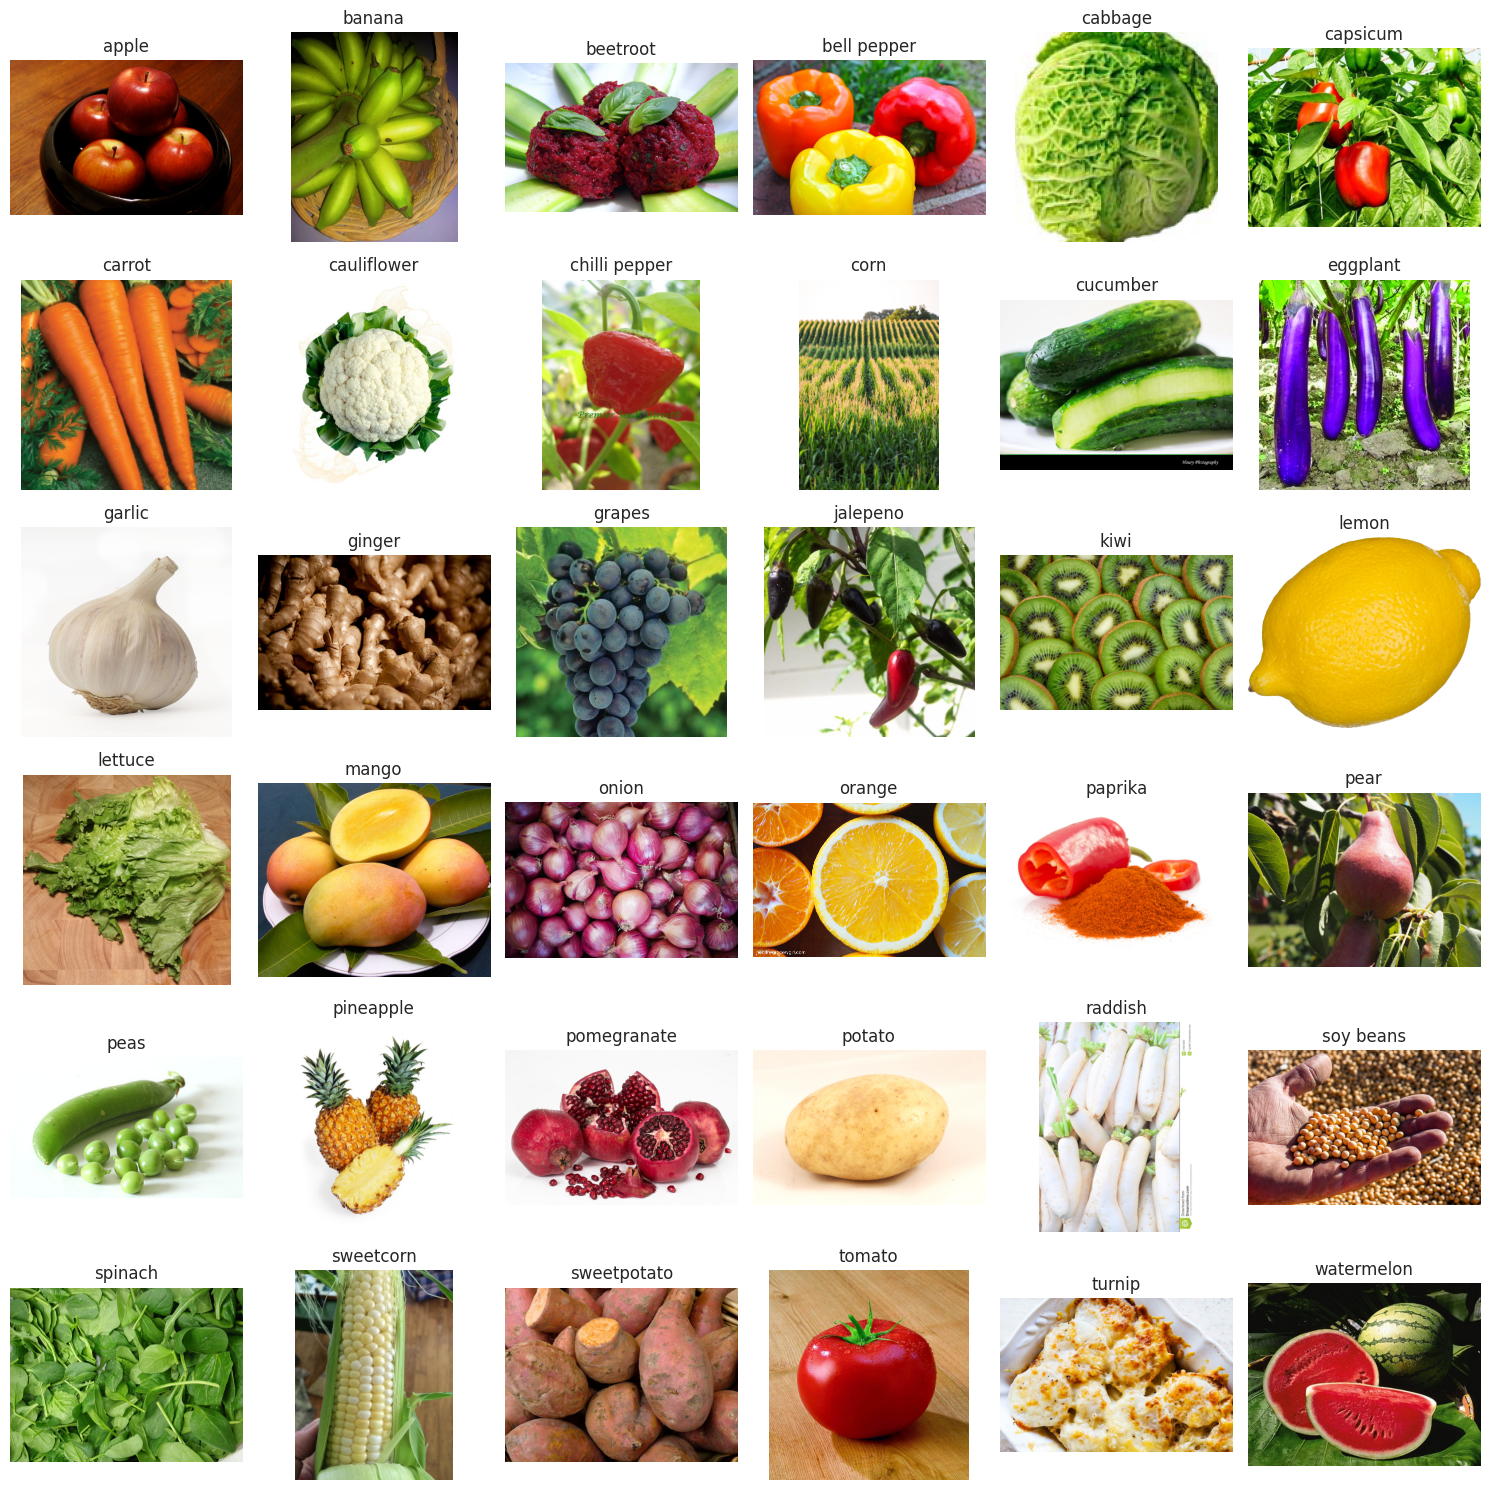

In [11]:
# --- Her Sınıftan Rastgele Bir Örnek Resim Gösterme ---

# Gerekli ek kütüphaneler
from PIL import Image # Resim dosyalarını açmak ve işlemek için
import random

# Grafik için bir alan oluşturalım. 36 sınıfı 6x6'lık bir gridde mükemmel bir şekilde gösterebiliriz.
plt.figure(figsize=(15, 15))

print("Her sınıftan rastgele bir örnek görsel yükleniyor...")

# Eğitim klasöründeki sınıfların isimlerini alfabetik olarak alalım
class_names_sorted = sorted(os.listdir(train_dir))

# Bu listedeki her bir sınıf için döngü başlatalım
# enumerate, hem sırayı (index) hem de değeri (class_name) aynı anda verir
for index, class_name in enumerate(class_names_sorted):

    # O anki sınıfın klasör yolunu oluşturalım
    class_path = os.path.join(train_dir, class_name)

    # O klasördeki tüm resim dosyalarının listesini alalım
    image_files = os.listdir(class_path)

    # Eğer klasör boş değilse (ki olmadığını biliyoruz) devam edelim
    if image_files:
        # Klasörden rastgele bir resim dosyası seçelim
        random_image_file = random.choice(image_files)

        # Seçtiğimiz resmin tam yolunu oluşturalım
        image_path = os.path.join(class_path, random_image_file)

        # Resmi açalım
        img = Image.open(image_path)

        # 6x6'lık gridimizde (toplam 36) doğru konuma resmi yerleştirelim
        plt.subplot(6, 6, index + 1)
        plt.imshow(img)

        # Başlık olarak sınıf adını yazalım
        plt.title(class_name)

        # Eksenleri (sayısal değerleri) gizleyerek daha temiz bir görünüm elde edelim
        plt.axis('off')

# Tüm alt grafikleri düzgün bir şekilde yerleştirelim ki birbirine girmesinler
plt.tight_layout()
# Ve son olarak tüm bu mozaik grafiği ekranda gösterelim
plt.show()

In [12]:
# --- Modelin Anlayacağı Veri Formatını Oluşturma ---

# Modelin kullanacağı resim boyutu ve batch ayarları
batch_size = 32
# Bu veri setindeki resimler daha çeşitli, 180x180 gibi daha büyük bir boyut kullanalım
img_height = 180
img_width = 180

# Eğitim setini 'train' klasöründen yükleyerek bir TensorFlow veri seti oluştur
print("Eğitim seti yükleniyor...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  label_mode='categorical', # 36 sınıfımız var, bu yüzden etiket modu 'categorical' olmalı
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Doğrulama setini 'validation' klasöründen yükle
print("Doğrulama seti yükleniyor...")
validation_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Test setini 'test' klasöründen yükle
print("Test seti yükleniyor...")
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Sınıf isimlerini daha sonra kullanmak üzere bir değişkene atayalım
class_names = train_ds.class_names
print(f"\nVeri setleri başarıyla oluşturuldu. Toplam sınıf sayısı: {len(class_names)}")

Eğitim seti yükleniyor...
Found 3115 files belonging to 36 classes.
Doğrulama seti yükleniyor...
Found 351 files belonging to 36 classes.
Test seti yükleniyor...
Found 359 files belonging to 36 classes.

Veri setleri başarıyla oluşturuldu. Toplam sınıf sayısı: 36


In [13]:
# --- Model Mimarisi'ni İnşa Etme ---

# Gerekli katmanları import edelim
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Sınıf sayısını alalım
num_classes = len(class_names)

# Katmanları sırayla ekleyeceğimiz 'Sequential' bir model oluşturuyoruz
model = Sequential([
  # Giriş katmanını ve normalizasyonu en başta tanımlıyoruz (Modern Yöntem)
  Input(shape=(img_height, img_width, 3)),
  Rescaling(1./255),

  # --- Özellik Çıkarıcı Bloklar ---
  Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D(),

  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(),

  Conv2D(128, (3, 3), activation='relu'),
  MaxPooling2D(),

  # --- Karar Mekanizması ---
  Flatten(), # 2D özellikleri 1D'ye çeviriyoruz

  # Yoğun katman (beyin) ve Dropout (ezberlemeyi önleyici)
  Dense(128, activation='relu'),
  Dropout(0.5), # Ezberlemeyi önlemek için nöronların %50'sini rastgele kapatır

  # Çıkış katmanı (36 sınıftan birinin olasılığını verecek)
  Dense(num_classes, activation='softmax')
])

# --- Modeli Derleme ---
# Modeli, öğrenme stratejisiyle birlikte eğitime hazırlıyoruz
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Etiketlerimiz 'categorical' olduğu için bu loss fonksiyonunu kullanıyoruz
    metrics=['accuracy']
)

# Modelin özetini görelim
print("Model Mimarisi Özeti:")
model.summary()

Model Mimarisi Özeti:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,651,620 (25.37 MB)

 Trainable params: 6,651,620 (25.37 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# --- Callback'leri (Akıllı Yardımcıları) Tanımlama ---

# EarlyStopping: 'val_accuracy' (doğrulama doğruluğu) 3 tur boyunca artmazsa eğitimi durdurur.
early_stopping = EarlyStopping(
    monitor='val_accuracy',      # İzlenecek metrik: Test setindeki doğruluk
    patience=3,                  # İyileşme olmazsa beklenecek tur (epoch) sayısı
    verbose=1,                   # Durdurulduğunda ekrana mesaj yaz
    mode='max',                  # İzlediğimiz metrik 'accuracy' olduğu için en yüksek değeri arıyoruz
    restore_best_weights=True    # Eğitimi durdurduğunda, bulduğu en iyi ağırlıklara geri döner
)

# ModelCheckpoint: Eğitim süresince elde edilen en iyi modeli bir dosyaya kaydeder.
model_checkpoint = ModelCheckpoint(
    'best_fruit_veg_model.h5',   # Kaydedilecek dosyanın adı
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,         # Sadece en iyi sonucu kaydet, her epoch'u değil
    verbose=1
)

# ReduceLROnPlateau: Modelin öğrenmesi yavaşladığında, öğrenme oranını düşürerek takılıp kalmasını engeller.
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.2,                  # Öğrenme oranını bu faktörle çarp (yani 5'e böl)
    patience=2,
    verbose=1,
    min_lr=0.00001               # Öğrenme oranının inebileceği en düşük seviye
)

# --- Modeli Eğitme ---

# Tanımladığımız tüm bu akıllı araçları tek bir listede toplayalım
callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

# Epoch sayısını yüksek tutabiliriz, çünkü EarlyStopping gerektiğinde eğitimi durduracak.
epochs = 15

print("Model eğitimi 'Callback'ler ile akıllı bir şekilde başlıyor...")

# .fit() fonksiyonunu çağırırken 'callbacks' parametresini kullanarak yardımcılarımızı eğitime dahil ediyoruz
history = model.fit(
  train_ds,
  validation_data=validation_ds, # Doğrulama için 'validation' setini kullanıyoruz
  epochs=epochs,
  callbacks=callbacks_list       # İşte sihir burada!
)

print("\nEğitim başarıyla tamamlandı!")

Model eğitimi 'Callback'ler ile akıllı bir şekilde başlıyor...
Epoch 1/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0427 - loss: 3.6020
Epoch 1: val_accuracy improved from -inf to 0.14245, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.0427 - loss: 3.6009 - val_accuracy: 0.1425 - val_loss: 3.2016 - learning_rate: 0.0010
Epoch 2/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1021 - loss: 3.2322
Epoch 2: val_accuracy improved from 0.14245 to 0.27920, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.1021 - loss: 3.2316 - val_accuracy: 0.2792 - val_loss: 2.6714 - learning_rate: 0.0010
Epoch 3/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1579 - loss: 2.9370
Epoch 3: val_accuracy improved from 0.27920 to 0.44444, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.1581 - loss: 2.9361 - val_accuracy: 0.4444 - val_loss: 2.0700 - learning_rate: 0.0010
Epoch 4/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2103 - loss: 2.6233
Epoch 4: val_accuracy improved from 0.44444 to 0.52137, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.2105 - loss: 2.6230 - val_accuracy: 0.5214 - val_loss: 1.7893 - learning_rate: 0.0010
Epoch 5/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2983 - loss: 2.3720
Epoch 5: val_accuracy improved from 0.52137 to 0.61254, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.2983 - loss: 2.3719 - val_accuracy: 0.6125 - val_loss: 1.4854 - learning_rate: 0.0010
Epoch 6/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3258 - loss: 2.2173
Epoch 6: val_accuracy improved from 0.61254 to 0.67806, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.3259 - loss: 2.2171 - val_accuracy: 0.6781 - val_loss: 1.2564 - learning_rate: 0.0010
Epoch 7/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3795 - loss: 2.0669
Epoch 7: val_accuracy improved from 0.67806 to 0.76638, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.3795 - loss: 2.0666 - val_accuracy: 0.7664 - val_loss: 1.0497 - learning_rate: 0.0010
Epoch 8/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4256 - loss: 1.8231
Epoch 8: val_accuracy improved from 0.76638 to 0.82051, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.4256 - loss: 1.8232 - val_accuracy: 0.8205 - val_loss: 0.8570 - learning_rate: 0.0010
Epoch 9/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4866 - loss: 1.6895
Epoch 9: val_accuracy improved from 0.82051 to 0.84046, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.4865 - loss: 1.6896 - val_accuracy: 0.8405 - val_loss: 0.7550 - learning_rate: 0.0010
Epoch 10/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5034 - loss: 1.5455
Epoch 10: val_accuracy improved from 0.84046 to 0.85185, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.5034 - loss: 1.5455 - val_accuracy: 0.8519 - val_loss: 0.6523 - learning_rate: 0.0010
Epoch 11/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5259 - loss: 1.4893
Epoch 11: val_accuracy improved from 0.85185 to 0.88034, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.5261 - loss: 1.4885 - val_accuracy: 0.8803 - val_loss: 0.5908 - learning_rate: 0.0010
Epoch 12/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5951 - loss: 1.2480
Epoch 12: val_accuracy improved from 0.88034 to 0.90883, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.5951 - loss: 1.2478 - val_accuracy: 0.9088 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 13/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6239 - loss: 1.1364
Epoch 13: val_accuracy improved from 0.90883 to 0.91738, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.6239 - loss: 1.1362 - val_accuracy: 0.9174 - val_loss: 0.3790 - learning_rate: 0.0010
Epoch 14/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6767 - loss: 1.0119
Epoch 14: val_accuracy improved from 0.91738 to 0.92593, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.6768 - loss: 1.0116 - val_accuracy: 0.9259 - val_loss: 0.3930 - learning_rate: 0.0010
Epoch 15/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6924 - loss: 0.9148
Epoch 15: val_accuracy improved from 0.92593 to 0.93732, saving model to best_fruit_veg_model.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.6925 - loss: 0.9148 - val_accuracy: 0.9373 - val_loss: 0.2867 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 15.

Eğitim başarıyla tamamlandı!


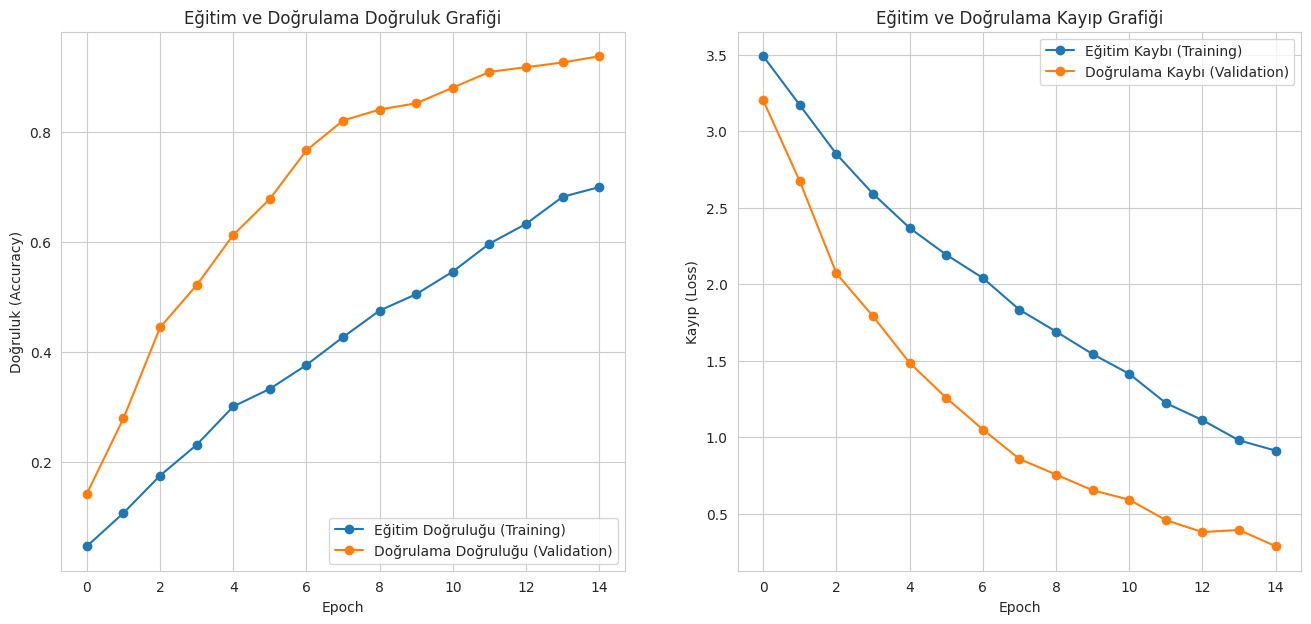

In [17]:
# --- Eğitim Sonuçlarını Görselleştirme (DÜZELTİLMİŞ VERSİYON) ---

# Eğitim geçmişinden doğru anahtar isimleriyle değerleri alıyoruz.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # 'validation_accuracy' -> 'val_accuracy' olarak düzeltildi
loss = history.history['loss']
val_loss = history.history['val_loss']      # 'validation_loss' -> 'val_loss' olarak düzeltildi

# Gerçekleşen epoch sayısını alıyoruz
num_actual_epochs = len(acc)
epochs_range = range(num_actual_epochs)

# Grafik çizimi için bir alan oluşturuyoruz.
plt.figure(figsize=(16, 7))

# 1. Grafik: Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'o-', label='Eğitim Doğruluğu (Training)')
plt.plot(epochs_range, val_acc, 'o-', label='Doğrulama Doğruluğu (Validation)') # Burası da düzeltildi
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (Accuracy)')

# 2. Grafik: Kayıp (Hata) Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'o-', label='Eğitim Kaybı (Training)')
plt.plot(epochs_range, val_loss, 'o-', label='Doğrulama Kaybı (Validation)') # Burası da düzeltildi
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')

# Grafikleri ekranda göster.
plt.show()

In [18]:
# --- En İyi Modelin Final Performansını Değerlendirme ---

# Gerekli kütüphaneyi import edelim
from tensorflow.keras.models import load_model

# Eğitim sırasında kaydettiğimiz en iyi modeli diskten yüklüyoruz.
# Bu, 'val_accuracy' değeri en yüksek olan modeldir.
print("Eğitimdeki en başarılı model 'best_fruit_veg_model.h5' yükleniyor...")
best_model = load_model('best_fruit_veg_model.h5')

# Bu en iyi modelin performansını, daha önce hiç kullanmadığımız 'test_ds' üzerinde ölçelim.
# model.evaluate() fonksiyonu, modelin bir veri seti üzerindeki loss ve accuracy değerlerini hesaplar.
print("\nEn iyi modelin 'Test Seti' üzerindeki nihai performansı değerlendiriliyor...")
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1) # verbose=1 ilerlemeyi gösterir

print("-" * 50)
print(f"Final Test Seti Doğruluğu (Accuracy): {test_accuracy * 100:.2f}%")
print(f"Final Test Seti Kaybı (Loss):      {test_loss:.4f}")
print("-" * 50)

Eğitimdeki en başarılı model 'best_fruit_veg_model.h5' yükleniyor...



En iyi modelin 'Test Seti' üzerindeki nihai performansı değerlendiriliyor...
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9204 - loss: 0.3088
--------------------------------------------------
Final Test Seti Doğruluğu (Accuracy): 93.59%
Final Test Seti Kaybı (Loss):      0.2864
--------------------------------------------------
